#                                      Modeling Price Transmission:
## Ethiopian Agricultural Commodity Markets


Trade flow research will help inform our understanding of price transmission in key agricultural markets related to food security.  Our goal is to improve on the following Trade Flow and Production map created by FEWS Net, based on Key Informant interviews and general knowledge.

### Trade Flow and Production (FEWS NET)
![](eth_maize.png)

In [97]:
import pandas as pd
import numpy as np
import calendar
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

We start off with importing and cleaning food price data from Fews Net and building the dataset we need to use.


In [98]:
########################
### FEWS NET DF  ######
    #-Import Data
market = pd.read_csv('fews_pub_price.csv')

pd.to_datetime(market['period_date'])
market = market.set_index('period_date')

#filter to data to Ethiopia
market_eth = market.loc[market['country']== 'Ethiopia']
# List of Product names then create list to filter
product_eth= market_eth.drop_duplicates(subset=['product'])['product'].tolist()
product_interest = ['Beans (Haricot)', 'Diesel', 'Gasoline', 'Horse beans', 'Maize Grain (White)', 'Mixed Teff', 'Refined Vegetable Oil', 'Rice (Milled)', 'Sorghum (Red)', 'Sorghum (White)', 'Sorghum (Yellow)', 'Wheat Grain']
    #--List of Fews Net Market Names
market_names= market_eth.drop_duplicates(subset=['market'])['market'].tolist()

#########################################
######  Analysis using Maize ####

market_maize = market_eth.loc[market_eth['product']=='Maize Grain (White)']

## finish Dataframe with market prices as separate columns##
trade_flow_maize = pd.DataFrame(columns=['period_date'])
trade_flow_maize = trade_flow_maize.set_index('period_date')
market_maize=market_maize.reset_index()

for name in market_names:
    m = market_maize.loc[market_maize['market'] == name]
    m= m[['period_date','value']]
    m.rename(columns={m.columns[1]: str(name) }, inplace=True)
    trade_flow_maize = pd.merge(trade_flow_maize,m,on = 'period_date', how='right')
trade_flow_maize['period_date']= pd.to_datetime(trade_flow_maize['period_date'])
trade_flow_maize= trade_flow_maize.sort_values(by='period_date')

tf_maize = trade_flow_maize.dropna(thresh=60, axis=1)
tf_maize.interpolate(method='linear', inplace=True)

tf_maize = tf_maize.set_index('period_date')

<ipython-input-98-0020d27a2ea7>:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



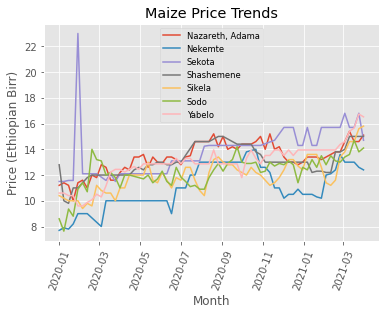

In [99]:
%matplotlib inline

plt.style.use('ggplot')
plt.plot(tf_maize['Nazareth, Adama'], label= 'Nazareth, Adama')
plt.plot(tf_maize['Nekemte'], label= 'Nekemte')
plt.plot(tf_maize['Sekota'], label= 'Sekota')
plt.plot(tf_maize['Shashemene'], label= 'Shashemene')
plt.plot(tf_maize['Sikela'], label= 'Sikela')
plt.plot(tf_maize['Sodo'], label= 'Sodo')
plt.plot(tf_maize['Yabelo'], label= 'Yabelo')
plt.xticks(rotation=70)
plt.legend(loc='best', fontsize='small')
plt.ylabel('Price (Ethiopian Birr)')
plt.xlabel('Month')
plt.title('Maize Price Trends')
plt.savefig("maize_trends.png")


## Measuring Price Transmission

We follow Nicholas Minot's work *Transmission of World Food Price Changes to Market* (2011) to explore the relationship in commodity food prices between markets in Eastern Africa. Specifically, we are looking at Ethiopia.
![](trade_flow2.png)

Minot uses a Vector Error Correction Model (VECM) to explore the link between Domestic and World prices for given countries and commodities. The analysis begins with confirming that the VECM is appropriate by setting two pre-conditions:

1) Given variable is Non-Stationary and integrated to degree 1, I(1).
    Follows random walk, but first difference (Xt - Xt-1) = I(0), or stationary
    This step uses the augmented Dickey-Fuller test and the Phillips-Perron test.
2) The two variables of interest are cointegrated,World price and domestic price, such that 
    World Pricet = α + βDomestic Pricet + ε or World Pricet - α - βDomestic Pricet = ε, where ε is stationary.
    This is done using the Johansen test.
    
If these conditions are met, we can proceed with estimating a VECM. Minot simplifies a standard VECM to the context by (1) assuming that all domestic markets are in small countries such that they do not influence the world price and (2) using only 1 lag as tests indicate this is sufficient.

$$ \Delta{p}_{t}^{d} = \alpha + \Theta({p}_{t-1}^{d} - \beta{p}_{t-1}^{w}) + \delta\Delta{p}_{t-1}^{w} + \rho\Delta{p}_{t-1}^{d} + \epsilon_{t} $$

Where ${p}_{t}^{d}$ is the log of domestic price converted to real U.S. dollars; 
${p}_{t}^{w}$ is the log of world price of the same commodity in real U.S. dollars; 
$\Delta$ is the difference operator, so $\Delta{p}_{t}^{d} = {p}_{t} – {p}_{t-1}$; 
$\alpha, \Theta, \beta, \delta, and \rho$ are estimated parameters; and $\epsilon_{t}$ is the error term


We start with testing for Non-Stationarity:

In [100]:
from statsmodels.tsa.stattools import adfuller

## Column names for loop
tf_names = ['Nazareth, Adama', 'Nekemte', 'Sekota', 'Shashemene', 'Sikela', 'Sodo',
       'Yabelo']

for name in tf_names:
    
    result= adfuller(tf_maize[name])
    print('The ', name, ' p-value is: ', result[1])


The  Nazareth, Adama  p-value is:  0.47268814096247946
The  Nekemte  p-value is:  0.22246826551059445
The  Sekota  p-value is:  0.8284212016439703
The  Shashemene  p-value is:  0.21761275894491994
The  Sikela  p-value is:  0.48209399441255973
The  Sodo  p-value is:  0.10510198520762165
The  Yabelo  p-value is:  0.9328031861328641


No Fews Net Monitered Markets show significance at the 5% level required to reject the null hypothesis that they are non-stationary. 

Now we can test for stationarity in the first difference.

In [101]:
trade_flow_dif = tf_maize
for name in tf_names:
    
    fdif = trade_flow_dif[name].diff()
    fdif = fdif.dropna()
    result = adfuller(fdif, autolag='AIC')
    print('The ', name, 'first difference adf p-value is: ', format(result[1], '.3f'))

The  Nazareth, Adama first difference adf p-value is:  0.000
The  Nekemte first difference adf p-value is:  0.005
The  Sekota first difference adf p-value is:  0.000
The  Shashemene first difference adf p-value is:  0.000
The  Sikela first difference adf p-value is:  0.000
The  Sodo first difference adf p-value is:  0.000
The  Yabelo first difference adf p-value is:  0.000


All markets but Aweil, Abusnoun, and Kayou are stationary in their first differences.

Next, we test for Cointegration between Fews Net markets using the Johansen Test.

In [106]:
from statsmodels.tsa.stattools import coint
##Create df for map to use later
market_link_df = pd.DataFrame(columns = ['market_1', 'm1_lat', 'm1_long', 'market_2', 'm2_lat', 'm2_long'])

    ##Loop to run cointegration test on all markets with Johansen test, Print only if significant
for market in tf_names:
    for m in tf_names:
        co = coint(tf_maize[m], tf_maize[market], maxlag = 1)
        if co[1] < 0.1:
            print(m, str(' and '), market + str(', p-value '), format(co[1], '.3f'))
            new_row = {'market_1':m, 'market_2': market}
            market_link_df = market_link_df.append(new_row, ignore_index=True)
    print('  ')

C:\Users\akeal\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1396: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.

C:\Users\akeal\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1396: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.

C:\Users\akeal\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1396: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.



Nazareth, Adama  and  Nazareth, Adama, p-value  0.000
Nekemte  and  Nazareth, Adama, p-value  0.000
Sekota  and  Nazareth, Adama, p-value  0.018
Shashemene  and  Nazareth, Adama, p-value  0.000
Sikela  and  Nazareth, Adama, p-value  0.078
Sodo  and  Nazareth, Adama, p-value  0.013
  
Nazareth, Adama  and  Nekemte, p-value  0.000
Nekemte  and  Nekemte, p-value  0.000
Sekota  and  Nekemte, p-value  0.015
Shashemene  and  Nekemte, p-value  0.001
Sodo  and  Nekemte, p-value  0.031
  
Sekota  and  Sekota, p-value  0.000
Sodo  and  Sekota, p-value  0.018
  
Nazareth, Adama  and  Shashemene, p-value  0.000
Nekemte  and  Shashemene, p-value  0.000
Sekota  and  Shashemene, p-value  0.028
Shashemene  and  Shashemene, p-value  0.000
Sodo  and  Shashemene, p-value  0.026
  
Sekota  and  Sikela, p-value  0.000
Sikela  and  Sikela, p-value  0.000
Sodo  and  Sikela, p-value  0.004
Yabelo  and  Sikela, p-value  0.020
  

C:\Users\akeal\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1396: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.

C:\Users\akeal\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1396: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.

C:\Users\akeal\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1396: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.




Sekota  and  Sodo, p-value  0.025
Sodo  and  Sodo, p-value  0.000
  
Sekota  and  Yabelo, p-value  0.000
Sikela  and  Yabelo, p-value  0.001
Sodo  and  Yabelo, p-value  0.008
Yabelo  and  Yabelo, p-value  0.000
  


C:\Users\akeal\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1396: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.



### Building the Map

The following code will allow us to build an interactive map through an automated process that will represent market cointegration.

In [107]:

# Add connections count for each market
market_link_df['count1'] = market_link_df.groupby('market_1')['market_1'].transform('count')
market_link_df['count2'] = market_link_df.groupby('market_2')['market_2'].transform('count')

In [108]:
coord_df = pd.read_csv('ethiopia_market_location.csv')
coord_df = coord_df[['market', 'latitude', 'longitude']]
##Add coordinates to market link df
coord_df = coord_df.drop_duplicates(subset=['market'])
market_link_df = market_link_df.drop(['m1_lat', 'm1_long', 'm2_lat','m2_long'], axis=1)
market_link_df = market_link_df.merge(coord_df, left_on='market_1', right_on='market', how='left')
market_link_df = market_link_df.rename(columns={"latitude": "m1_lat", "longitude": "m1_long"})
market_link_df = market_link_df.merge(coord_df, left_on='market_2', right_on='market', how='left')
market_link_df = market_link_df.rename(columns={"latitude": "m2_lat", "longitude": "m2_long"})


In [110]:
# Merge connections count with coordinates df
coord_df = coord_df.merge(market_link_df, left_on='market', right_on='market_2', how='left')[['market', 'latitude',
                                                    'longitude', 'count2']].drop_duplicates(subset=['market'])
coord_df = coord_df.merge(market_link_df, left_on='market', right_on='market_1', how='left')[['market', 'latitude',
                                        'longitude', 'count2_x', 'count1']].drop_duplicates(subset=['market'])
coord_df['count2_x'].update(coord_df.pop('count1'))
# Dirty way to scale count values
coord_df['count2_x'] = coord_df['count2_x'].fillna(0) + 1
coord_df['count'] = (np.log(coord_df['count2_x'])+1)*4

In [111]:
# Plot Scattermapbox figure
mapbox_accesstoken = "pk.eyJ1Ijoia2ltZXRyaWNhIiwiYSI6ImNqOXBhcmZ4MjV3bXUyeHFzOHl0dThvMnkifQ.iJZQgevKXD_Hz7HpbPCHDA"
fig = go.Figure()
fig.add_trace(
    go.Scattermapbox(
        name="markets",
        lon=coord_df['longitude'],
        lat=coord_df['latitude'],
        mode='markers+text',
        text=coord_df['market'],
        textfont=dict(size=12, color='black'),
        textposition="top center",
        marker=dict(
            opacity=0.6,
            size=coord_df['count'],
            color='rgb(255, 0, 0)',
        ),
        hovertemplate="%{text}" + "<extra></extra>",
    )
)
market_links = []
for i in range(len(market_link_df)):
    fig.add_trace(
        go.Scattermapbox(
            name='links',
            lon=[market_link_df['m1_long'][i], market_link_df['m2_long'][i]],
            lat=[market_link_df['m1_lat'][i], market_link_df['m2_lat'][i]],
            mode='lines',
            line=dict(width=0.7, color='#1845cd'),
            opacity=0.7,
            text=market_link_df['market_1'] + "-" + market_link_df['market_2'],
            hovertemplate="%{text}" + "<extra></extra>",
        )
    )
fig.update_layout(
    showlegend=False,
    mapbox=dict(
            accesstoken=mapbox_accesstoken,
            style="mapbox://styles/kimetrica/ckkhg2drg1b4x18th1s7cnhn3",
            center=dict(lon=38, lat=9),
            zoom=5,
        ),
)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

The map above shows the market links where cointegration was found.  This is a first step in better understanding how price is transmitted through the region. A next step would be to incorporate direction and strength of relationship.

## Results

Transmission of Sorghum prices from Sekota to FEWS NET monitored markets in Ethiopia.

 Market    | Commodity | Staionary in 1st Dif (ADF Test) | Long-run Relationship (Johansen test) |Speed of Adjustment | Short-run Adjustment    | Long-run Adjustment           
 :---------| :-------- | :------: | :-----------------: | :------------------: | :-----------------: | :---:
 Nekemte  | Maize   |     Yes   |    Yes               |      0.1554     | 0.0319 | 0.2961*** |
 Shashemene | Maize   |      Yes  |   Yes                |    0.0780            | -0.0078 | 0.1376 |    
Sikela | Maize |  Yes | Yes |  -0.4420***   | -0.0361 | -0.5395*** | |
 Sodo | Maize |   Yes| Yes| 0.3199* | 0.0998** | -0.5178*** | |
Nazareth, Adama | Maize |  Yes|Yes |-0.3924*** | 0.0575* | -0.2276* | |
 Yabelo | Maize |   Yes|Yes | 0.0348 | -0.0143 | -0.1428*** | |

P-value: * = 0.1, ** = 0.05, *** = 0.01


In [112]:
##VECM Test
from statsmodels.tsa.vector_ar.vecm import VECM, select_order

ar_model = VECM(tf_maize, k_ar_diff=1, coint_rank=1)
ar = ar_model.fit() 
ar.summary()

C:\Users\akeal\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-WED will be used.



,coef,std err,z,P>|z|,[0.025,0.975]
"L1.Nazareth, Adama",-0.2233,0.115,-1.943,0.052,-0.449,0.002
L1.Nekemte,0.0420,0.102,0.411,0.681,-0.158,0.242
L1.Sekota,0.0575,0.031,1.879,0.060,-0.002,0.118
L1.Shashemene,-0.0760,0.133,-0.571,0.568,-0.337,0.185
L1.Sikela,0.2467,0.095,2.605,0.009,0.061,0.432
L1.Sodo,-0.1173,0.074,-1.589,0.112,-0.262,0.027
L1.Yabelo,-0.3231,0.141,-2.285,0.022,-0.600,-0.046
,coef,std err,z,P>|z|,[0.025,0.975]
"L1.Nazareth, Adama",-0.0766,0.134,-0.573,0.567,-0.339,0.186
L1.Nekemte,-0.1097,0.119,-0.922,0.357,-0.343,0.123


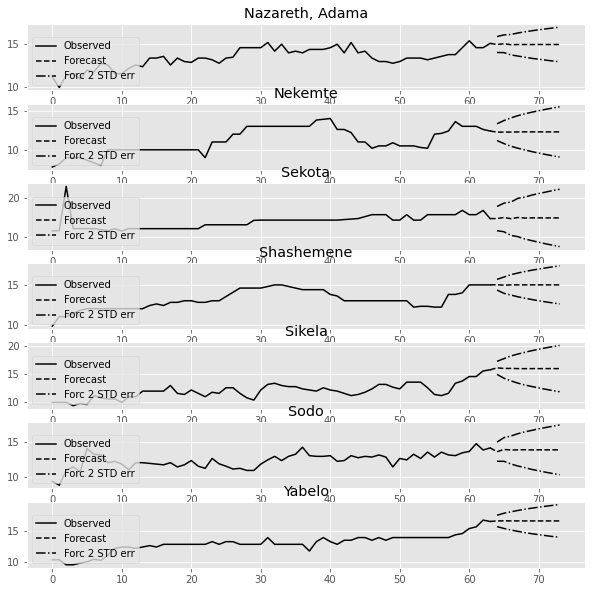

In [113]:
ar.predict(steps=5)
ar.plot_forecast(steps=10)

C:\Users\akeal\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-WED will be used.



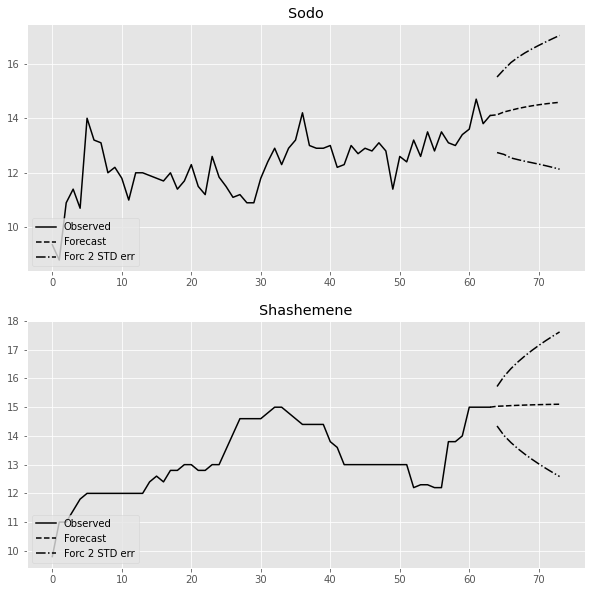

In [114]:
ar_model = VECM(tf_maize[['Sodo', 'Shashemene']], k_ar_diff=1, coint_rank=1)
mod1 = ar_model.fit() 
mod1.summary()
mod1.predict(steps=5)
mod1.plot_forecast(steps=10)

In [115]:
## Testing Granger Causality

ar.test_granger_causality(caused="Sodo", causing="Sekota").summary()

Test statistic,Critical value,p-value,df
2.804,3.026,0.062,"(2, 294)"
